# Import Libraries

In [62]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.regularizers import l2
from keras.layers import Dropout
import matplotlib.pyplot as plt
import math
from os import listdir
from os.path import isfile, join
import re
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import TimeDistributed

from keras.callbacks import ModelCheckpoint
import re
import os
import shutil

In [63]:
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
#from cluster_lists import *
import re
import os
import shutil
# print(tf.config.list_physical_devices('GPU'))
import math

In [64]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [65]:
from sklearn.model_selection import train_test_split

# Load Data

## Data

In [72]:
df = pd.read_csv("fulldata_2024_202506.csv", sep=';')
df['UTC'] = pd.to_datetime(df['UTC'], format="%d.%m.%Y %H:%M")
df = df[['UTC', 'Spot CH [Euro/MWh]', 'Total_System_Imbalance__Positiv_:_long_/_Negativ_:_short_ [MW]']].copy()
df.set_index('UTC', inplace=True)
df.sort_index(inplace=True)
#df.loc[:'2024']
df = df[['Spot CH [Euro/MWh]', 'Total_System_Imbalance__Positiv_:_long_/_Negativ_:_short_ [MW]']].copy()
df.rename(columns={
    'Spot CH [Euro/MWh]': 'spot',
    'Total_System_Imbalance__Positiv_:_long_/_Negativ_:_short_ [MW]':'imbalance'}, inplace=True)

In [73]:
df.head()

,spot,imbalance
UTC,,
2023-12-31 23:00:00,25.969999,-140.366068
2023-12-31 23:15:00,25.969999,-128.665522
2023-12-31 23:30:00,25.969999,-102.094778
2023-12-31 23:45:00,25.969999,-105.304430
2024-01-01 00:00:00,21.990000,-258.536247


## Synthetic data

In [ ]:
rng = pd.date_range('2021-01-01', '2021-01-10 23:45', freq='15min')
df = pd.DataFrame({
    'IRR': np.sin(np.arange(len(rng))/20.0) + np.random.normal(0, 0.1, len(rng)),
    'WERT': np.cos(np.arange(len(rng))/30.0) + np.random.normal(0, 0.1, len(rng)),
}, index=rng)

df.rename(columns={'IRR':'Feature', 'WERT':'Target'}, inplace=True)

# Functions

In [67]:
def my_digit_sort(columns_list):
    return list(map(int, re.findall(r'\d+', columns_list)))[0]

def multivar_series_to_supervised_v3(
    data: pd.DataFrame,
    col_names: list,            # any length >= 1, e.g. ['WERT'], ['WERT','IRR'], ['A','B','C', ...]
    past_steps: int,            # number of historical timestamps to include
    name: str = "supervised.csv",
    train_data: bool = False,
    steps_per_day: int = 96,    # stride/anchor spacing
    future_steps: int = 52      # number of future steps starting at t (0..future_steps-1)
):
    """
    For each anchor t0 (every steps_per_day ticks) create one row:
      History:  for i = past_steps..1, append <feat>(t-i) for all feats in col_names (in given order)
      Future:   for each feat in col_names, append <feat>(t), <feat>(t+1), ..., <feat>(t+future_steps-1)
    Returns a DataFrame with DatetimeIndex 't0'.
    """
    if not isinstance(col_names, (list, tuple)) or len(col_names) < 1:
        raise ValueError("col_names must be a list/tuple with at least one column name.")
    for c in col_names:
        if c not in data.columns:
            raise ValueError(f"Column {c!r} not found in data.")

    df = pd.DataFrame(data).copy().sort_index()
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame index must be a DatetimeIndex.")

    n = len(df)
    if past_steps < 1 or future_steps < 1 or steps_per_day < 1:
        raise ValueError("past_steps, future_steps, steps_per_day must be >= 1.")

    # Build column names: history first (largest lag to smallest), then futures grouped by feature
    names = []
    for i in range(past_steps, 0, -1):
        for feat in col_names:
            names.append(f'var_{feat}s(t-{i})')
    for feat in col_names:
        names.append(f'var_{feat}s(t)')
        names += [f'var_{feat}s(t+{k})' for k in range(1, future_steps)]

    # Anchor timestamps (keep DatetimeIndex in the result)
    pos = pd.Series(range(n), index=df.index)
    anchors = []
    for i0 in range(0, n, steps_per_day):
        if i0 - past_steps < 0:
            continue
        if i0 + future_steps - 1 >= n:
            break
        anchors.append(df.index[i0])

    # Build rows
    rows = []
    for t0 in anchors:
        i0 = pos.loc[t0]
        vals = []

        # History values
        for i in range(past_steps, 0, -1):
            p = i0 - i
            for feat in col_names:
                vals.append(df[feat].iloc[p])

        # Future values by feature
        for feat in col_names:
            for k in range(0, future_steps):
                vals.append(df[feat].iloc[i0 + k])

        rows.append(vals)

    agg = pd.DataFrame(rows, columns=names, index=pd.DatetimeIndex(anchors, name='t0'))

    # Optional re-ordering: keep history first (sorted by largest lag), then futures (already grouped)
    hist_cols = [c for c in agg.columns if '(t-' in c]
    fut_cols = [c for c in agg.columns if '(t' in c and '(t-' not in c]
    hist_cols_sorted = sorted(hist_cols, key=my_digit_sort, reverse=True)
    agg = agg[hist_cols_sorted + fut_cols]

    if train_data:
        os.makedirs('data_supervised_auto', exist_ok=True)
        path = os.path.join('data_supervised_auto', name)
        agg.to_csv(path)  # keep DatetimeIndex
    else:
        return agg


def build_XY_for_horizon(agg: pd.DataFrame, target_feature: str, future_horizon: int = 4):
    """
    Extract X and Y from the aggregated supervised df.
    - X: all history columns + optionally all 'current/future' columns of non-targets (commonly: only history).
    - Y: target_feature at t..t+future_horizon-1 (e.g., 4 -> t..t+3).
    """
    # Identify columns
    hist_cols = [c for c in agg.columns if '(t-' in c]
    # All future columns for the target
    y_cols = [f'var_{target_feature}s(t)'] + [f'var_{target_feature}s(t+{k})' for k in range(1, future_horizon)]
    # Sanity check that they exist
    missing = [c for c in y_cols if c not in agg.columns]
    if missing:
        raise ValueError(f"Missing target columns: {missing}")

    # X: by default use only history columns (safer for leakage)
    X = agg[hist_cols].copy()
    Y = agg[y_cols].copy()

    return X, Y

In [68]:
def build_lstm_baseline(timesteps, n_features, out_steps, lstm_units=64, dense_units=64, dropout=0.2):
    model = Sequential([
        LSTM(lstm_units, input_shape=(timesteps, n_features), return_sequences=False),
        BatchNormalization(),
        Dropout(dropout),
        Dense(dense_units, activation='relu'),
        Dense(out_steps)  # linear outputs for regression
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [69]:
learning_rate = 0.001
def lr_decay(epoch, initial_lr=learning_rate):
    drop = 0.98
    epochs_drop = 10.0
    lr = initial_lr * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lr

def build_lstm_custom(timesteps, n_features, out_steps):
    """
    Recreates the model you specified:
      Bidirectional(LSTM(4, return_sequences=True))
      Dropout(0.1)
      LSTM(6, return_sequences=True)
      LSTM(6)
      Dense(out_steps)
    Compiled with Adam(lr=learning_rate) and MSE loss.
    Returns (model, lr_scheduler_callback)
    """
    model = Sequential()
    # Input shape = (timesteps, n_features)
    model.add(Bidirectional(LSTM(4, return_sequences=True), input_shape=(timesteps, n_features)))
    model.add(Dropout(0.1))
    model.add(LSTM(6, return_sequences=True))
    model.add(LSTM(6))
    model.add(Dense(out_steps))

    opt = Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='mse', metrics=['mae'])

    lr_scheduler = LearningRateScheduler(lr_decay, verbose=1)
    return model, lr_scheduler

In [70]:
def plot_training_history(history):
    hist = history.history
    epochs = range(1, len(hist['loss']) + 1)

    plt.figure(figsize=(12,4))
    # Loss
    plt.subplot(1,2,1)
    plt.plot(epochs, hist['loss'], label='Train loss')
    if 'val_loss' in hist:
        plt.plot(epochs, hist['val_loss'], label='Val loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE loss')
    plt.title('Training history - Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # MAE
    plt.subplot(1,2,2)
    if 'mae' in hist:
        plt.plot(epochs, hist['mae'], label='Train MAE')
    if 'val_mae' in hist:
        plt.plot(epochs, hist['val_mae'], label='Val MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.title('Training history - MAE')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_forecast_examples(y_true, y_pred, n_examples=5, horizons_to_plot=(0,1,2,3)):
    """
    Plot several examples of predicted vs. true trajectories across horizons.
    y_true, y_pred: arrays [samples, out_steps]
    horizons_to_plot: which horizons to show (0=t, 1=t+1, etc.)
    """
    out_steps = y_true.shape[1]
    horizons_to_plot = [h for h in horizons_to_plot if h < out_steps]

    fig, axes = plt.subplots(len(horizons_to_plot), 1, figsize=(12, 3*len(horizons_to_plot)), sharex=True)
    if len(horizons_to_plot) == 1:
        axes = [axes]

    idx = np.arange(min(n_examples, len(y_true)))

    for ax, h in zip(axes, horizons_to_plot):
        ax.plot(idx, y_true[idx, h], 'o-', label=f'True t+{h}')
        ax.plot(idx, y_pred[idx, h], 'o--', label=f'Pred t+{h}')
        ax.set_ylabel('Value')
        ax.set_title(f'Horizon t+{h}')
        ax.grid(True, alpha=0.3)
        ax.legend()

    axes[-1].set_xlabel('Example index')
    plt.tight_layout()
    plt.show()

def plot_trajectory(y_true, y_pred, sample_idx=0):
    """
    Plot full multi-step trajectory for one test sample.
    """
    steps = np.arange(y_true.shape[1])
    plt.figure(figsize=(10,4))
    plt.plot(steps, y_true[sample_idx], 'o-', label='True')
    plt.plot(steps, y_pred[sample_idx], 'o--', label='Predicted')
    plt.xticks(steps, [f't+{k}' for k in steps])
    plt.xlabel('Horizon')
    plt.ylabel('Value')
    plt.title(f'Forecast trajectory for sample {sample_idx}')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [77]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def scale_dataframe(
    df: pd.DataFrame,
    scaler_type: str = "standard",   # "standard" or "minmax"
    split_index: int | None = None,  # row index where test starts; if None, fit on all rows
    feature_cols: list | None = None # which columns to scale; default = all numeric
):
    """
    Scale an entire DataFrame with one scaler.
    - scaler_type: "standard" (StandardScaler) or "minmax" (MinMaxScaler).
    - split_index: if provided, the scaler is fit on df.iloc[:split_index] only,
                   and then applied to the full DataFrame. Useful for time-series.
                   If None, fit on the entire df (not recommended for modeling, but handy).
    - feature_cols: list of column names to scale. By default, all numeric columns are scaled.
                    Non-scaled columns are preserved and concatenated back.

    Returns:
      scaled_df: DataFrame of same shape/index/columns with scaled values for selected columns.
      scaler: the fitted scaler object (save and reuse for inference).
    """
    if feature_cols is None:
        feature_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if len(feature_cols) == 0:
        raise ValueError("No numeric columns found to scale. Provide feature_cols explicitly.")

    if scaler_type.lower() == "standard":
        scaler = StandardScaler()
    elif scaler_type.lower() == "minmax":
        scaler = MinMaxScaler()
    else:
        raise ValueError("scaler_type must be 'standard' or 'minmax'.")

    df = df.copy()
    numeric_part = df[feature_cols].values

    # Fit on train slice or full
    if split_index is not None:
        if split_index <= 0 or split_index >= len(df):
            raise ValueError("split_index must be within (0, len(df)) for a train/test split fit.")
        scaler.fit(numeric_part[:split_index])
        scaled_numeric = scaler.transform(numeric_part)
    else:
        scaler.fit(numeric_part)
        scaled_numeric = scaler.transform(numeric_part)

    # Recombine with non-scaled columns
    scaled_df = df.copy()
    scaled_df[feature_cols] = scaled_numeric

    return scaled_df, scaler

def inverse_scale_targets(y_scaled: np.ndarray, scaler, y_columns: list, all_columns: list):
    """
    Invert scaling for Y when the scaler was fit on a combined (X+y) matrix.
    We create a dummy array with shape (n_samples, len(all_columns)), put y_scaled
    into the Y column positions, inverse_transform, then select Y columns back.
    """
    n_samples = y_scaled.shape[0]
    tmp = np.zeros((n_samples, len(all_columns)))
    # indices of Y columns inside the combined scaler space
    y_idx = [all_columns.index(c) for c in y_columns]
    tmp[:, y_idx] = y_scaled
    tmp_inv = scaler.inverse_transform(tmp)
    y_inv = tmp_inv[:, y_idx]
    return y_inv

def evaluate_multistep(y_true, y_pred, prefix="Test"):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    # per-horizon metrics
    mae_h = np.mean(np.abs(y_true - y_pred), axis=0)
    rmse_h = np.sqrt(np.mean((y_true - y_pred)**2, axis=0))
    print(f"{prefix} RMSE: {rmse:.4f} | MAE: {mae:.4f}")
    for h, (m_h, r_h) in enumerate(zip(mae_h, rmse_h)):
        print(f"  t+{h}: MAE={m_h:.4f} | RMSE={r_h:.4f}")
    return {"rmse": rmse, "mae": mae, "mae_h": mae_h, "rmse_h": rmse_h}

# Script

In [74]:
df

,spot,imbalance
UTC,,
2023-12-31 23:00:00,25.969999,-140.366068
2023-12-31 23:15:00,25.969999,-128.665522
2023-12-31 23:30:00,25.969999,-102.094778
2023-12-31 23:45:00,25.969999,-105.304430
2024-01-01 00:00:00,21.990000,-258.536247
...,...,...
2025-06-30 20:30:00,142.940002,-116.768141
2025-06-30 20:45:00,142.940002,-53.999116
2025-06-30 21:00:00,115.889999,-218.654147


In [75]:
df = multivar_series_to_supervised_v3(df, past_steps=96, future_steps=4, steps_per_day=1, col_names=['spot', 'imbalance'])

In [76]:
df

,var_spots(t-96),var_imbalances(t-96),var_spots(t-95),var_imbalances(t-95),var_spots(t-94),var_imbalances(t-94),var_spots(t-93),var_imbalances(t-93),var_spots(t-92),var_imbalances(t-92),...,var_spots(t-1),var_imbalances(t-1),var_spots(t),var_spots(t+1),var_spots(t+2),var_spots(t+3),var_imbalances(t),var_imbalances(t+1),var_imbalances(t+2),var_imbalances(t+3)
t0,,,,,,,,,,,,,,,,,,,,,
2024-01-01 23:00:00,25.969999,-140.366068,25.969999,-128.665522,25.969999,-102.094778,25.969999,-105.304430,21.990000,-258.536247,...,26.070000,-23.789611,22.240000,22.240000,22.240000,22.240000,-122.745408,-103.733928,-47.027721,0.243507
2024-01-01 23:15:00,25.969999,-128.665522,25.969999,-102.094778,25.969999,-105.304430,21.990000,-258.536247,21.990000,-234.386177,...,22.240000,-122.745408,22.240000,22.240000,22.240000,14.000000,-103.733928,-47.027721,0.243507,-126.236049
2024-01-01 23:30:00,25.969999,-102.094778,25.969999,-105.304430,21.990000,-258.536247,21.990000,-234.386177,21.990000,-216.840181,...,22.240000,-103.733928,22.240000,22.240000,14.000000,14.000000,-47.027721,0.243507,-126.236049,-78.092763
2024-01-01 23:45:00,25.969999,-105.304430,21.990000,-258.536247,21.990000,-234.386177,21.990000,-216.840181,21.990000,-155.826250,...,22.240000,-47.027721,22.240000,14.000000,14.000000,14.000000,0.243507,-126.236049,-78.092763,-48.901592
2024-01-02 00:00:00,21.990000,-258.536247,21.990000,-234.386177,21.990000,-216.840181,21.990000,-155.826250,14.320000,-283.000847,...,22.240000,0.243507,14.000000,14.000000,14.000000,14.000000,-126.236049,-78.092763,-48.901592,4.750371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-30 19:45:00,118.120003,-177.032786,117.959999,-256.190747,117.959999,-212.048933,117.959999,-172.646407,117.959999,-120.067517,...,171.919998,-173.966404,171.919998,142.940002,142.940002,142.940002,-110.340153,-259.817748,-185.622398,-116.768141
2025-06-30 20:00:00,117.959999,-256.190747,117.959999,-212.048933,117.959999,-172.646407,117.959999,-120.067517,105.620003,-245.258390,...,171.919998,-110.340153,142.940002,142.940002,142.940002,142.940002,-259.817748,-185.622398,-116.768141,-53.999116
2025-06-30 20:15:00,117.959999,-212.048933,117.959999,-172.646407,117.959999,-120.067517,105.620003,-245.258390,105.620003,-182.134550,...,142.940002,-259.817748,142.940002,142.940002,142.940002,115.889999,-185.622398,-116.768141,-53.999116,-218.654147


In [78]:
scaled_df, scaler = scale_dataframe(df)

In [87]:
scaled_df

,var_spots(t-96),var_imbalances(t-96),var_spots(t-95),var_imbalances(t-95),var_spots(t-94),var_imbalances(t-94),var_spots(t-93),var_imbalances(t-93),var_spots(t-92),var_imbalances(t-92),...,var_spots(t-1),var_imbalances(t-1),var_spots(t),var_spots(t+1),var_spots(t+2),var_spots(t+3),var_imbalances(t),var_imbalances(t+1),var_imbalances(t+2),var_imbalances(t+3)
t0,,,,,,,,,,,,,,,,,,,,,
2024-01-01 23:00:00,-1.316382,-0.632779,-1.316435,-0.565796,-1.316488,-0.413718,-1.316541,-0.432084,-1.405615,-1.309064,...,-1.318923,0.035944,-1.404740,-1.404800,-1.404860,-1.404920,-0.529859,-0.421141,-0.096914,0.173369
2024-01-01 23:15:00,-1.316382,-0.565814,-1.316435,-0.413726,-1.316488,-0.432088,-1.405560,-1.309060,-1.405615,-1.170848,...,-1.404689,-0.529862,-1.404740,-1.404800,-1.404860,-1.589449,-0.421155,-0.096911,0.173370,-0.549807
2024-01-01 23:30:00,-1.316382,-0.413742,-1.316435,-0.432096,-1.405506,-1.309065,-1.405560,-1.170844,-1.405615,-1.070429,...,-1.404689,-0.421159,-1.404740,-1.404800,-1.589386,-1.589449,-0.096922,0.173372,-0.549805,-0.274537
2024-01-01 23:45:00,-1.316382,-0.432112,-1.405452,-1.309076,-1.405506,-1.170849,-1.405560,-1.070425,-1.405615,-0.721234,...,-1.404689,-0.096926,-1.404740,-1.589324,-1.589386,-1.589449,0.173363,-0.549802,-0.274535,-0.107630
2024-01-02 00:00:00,-1.405397,-1.309101,-1.405452,-1.170860,-1.405506,-1.070430,-1.405560,-0.721231,-1.577169,-1.449080,...,-1.404689,0.173360,-1.589261,-1.589324,-1.589386,-1.589449,-0.549817,-0.274532,-0.107628,0.199138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-30 19:45:00,0.744613,-0.842634,0.741011,-1.295652,0.740988,-1.043008,0.740965,-0.817496,0.740941,-0.516580,...,1.947141,-0.822732,1.947093,1.298113,1.298091,1.298070,-0.458928,-1.313585,-0.889360,-0.495672
2025-06-30 20:00:00,0.741034,-1.295677,0.741011,-1.043019,0.740988,-0.817500,0.740965,-0.516576,0.464933,-1.233072,...,1.947141,-0.458932,1.298134,1.298113,1.298091,1.298070,-1.313607,-0.889357,-0.495670,-0.136776
2025-06-30 20:15:00,0.741034,-1.043041,0.741011,-0.817509,0.740988,-0.516580,0.464961,-1.233068,0.464933,-0.871802,...,1.298183,-1.313610,1.298134,1.298113,1.298091,0.692304,-0.889375,-0.495667,-0.136774,-1.078228


In [91]:
X = scaled_df.iloc[:, :-4]
y = scaled_df.iloc[:, -4:]

In [80]:
#X, y = build_XY_for_horizon(scaled_df, 'imbalance') # splitting into X and y

In [93]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
FEATURES = 1

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41, shuffle=True)

x_train_r = np.array(x_train).reshape((x_train.shape[0], int(X.shape[1]/FEATURES), FEATURES))
x_test_r = np.array(x_test).reshape((x_test.shape[0], int(X.shape[1]/FEATURES), FEATURES))

In [94]:
y_train.shape[1]

4

In [95]:
# Inspect shapes
timesteps = x_train_r.shape[1] # 96
n_features = x_train_r.shape[2] # 2
out_steps = y_train.shape[1] # 4

model, lr_sched = build_lstm_custom(timesteps, n_features, out_steps)
history = model.fit(
    x_train_r, y_train,
    validation_split=0.1,
    epochs=5,
    batch_size=96,
    callbacks=[lr_sched],  # add EarlyStopping if desired
    verbose=1
)

C:\Users\ckw-megi\OneDrive - CKW-Gruppe\Projekte\hackdays\venv\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 94s 251ms/step - loss: 0.8136 - mae: 0.6468 - val_loss: 0.6254 - val_mae: 0.5373 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 66s 193ms/step - loss: 0.4857 - mae: 0.4951 - val_loss: 0.4599 - val_mae: 0.4527 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 62s 179ms/step - loss: 0.4153 - mae: 0.4613 - val_loss: 0.4271 - val_mae: 0.4363 - learning_rate: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 79s 169ms/step - loss: 0.3922 - mae: 0.4501 - val_loss: 0.4094 - val_mae: 0.4273 - learning_rate: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 5/5
344/344 ━━━━━━

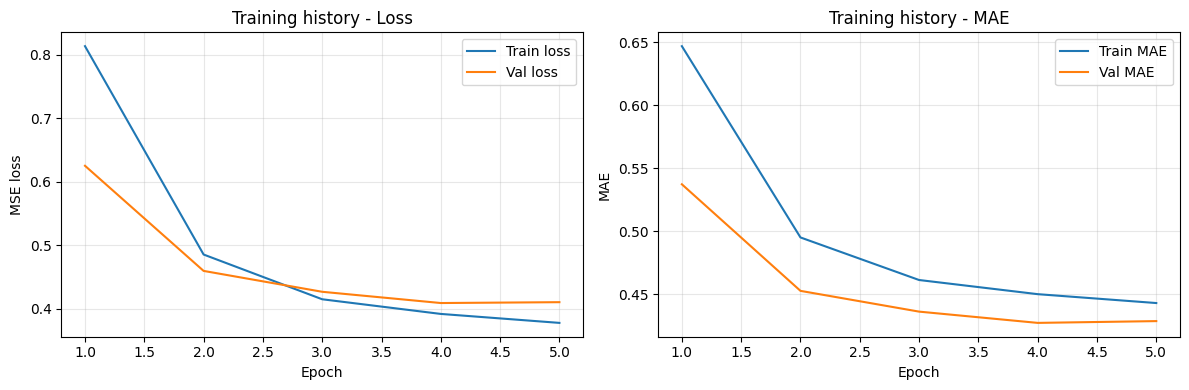

In [96]:
plot_training_history(history)

In [97]:
y_pred_s = model.predict(x_test_r)


492/492 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step


In [98]:
y_pred_s

array([[-0.06987349, -0.06092829, -0.08213239, -0.12074123],
       [ 0.06124163,  0.0157247 ,  0.01346544,  0.01587908],
       [ 0.6119134 ,  0.6344013 ,  0.5885363 ,  0.5653498 ],
       ...,
       [-1.076522  , -1.1121215 , -1.0348727 , -0.97145736],
       [-0.22232693, -0.28110808, -0.25543773, -0.23714396],
       [-0.2135751 , -0.25980234, -0.23773962, -0.22695753]],
      shape=(15723, 4), dtype=float32)

In [100]:
y_test_inv = inverse_scale_targets(y_test, scaler, y_columns=y.columns.tolist(), all_columns=scaled_df.columns.tolist())
y_pred_inv = inverse_scale_targets(y_pred_s, scaler, y_columns=y.columns.tolist(), all_columns=scaled_df.columns.tolist())


In [103]:
y_test_inv

array([[  16.80891889,  -76.65502667,  -49.59198111,   -0.69573667],
       [ -58.15747444,  -94.49932444,  210.0809844 ,   38.20634   ],
       [  87.96755   ,  135.0742044 ,   71.76457556,  102.0912944 ],
       ...,
       [-391.6649356 , -381.5277644 , -381.88016   , -347.4571744 ],
       [ -12.40923111, -207.2191422 , -131.1056556 ,  -59.59121111],
       [ -62.63028889,  -33.14381444,  -21.83102556, -115.3966389 ]],
      shape=(15723, 4))

In [104]:
y_pred_inv

array([[ -42.29703314,  -40.73449701,  -44.44252444,  -51.19473655],
       [ -19.3658645 ,  -27.32828305,  -27.72296963,  -27.30056939],
       [  76.9429852 ,   80.87508045,   72.85388198,   68.79894446],
       ...,
       [-218.35320383, -224.58278235, -211.07175047, -199.98046949],
       [ -68.96013315,  -79.24281097,  -74.75271067,  -71.55295589],
       [ -67.42949428,  -75.51654652,  -71.6574051 ,  -69.77140272]],
      shape=(15723, 4))

In [105]:
evaluate_multistep(y_test_inv, y_pred_inv, prefix="Test")


Test RMSE: 105.1803 | MAE: 74.7381
  t+0: MAE=71.2202 | RMSE=96.6895
  t+1: MAE=74.2650 | RMSE=100.2639
  t+2: MAE=74.5896 | RMSE=108.3408
  t+3: MAE=78.8776 | RMSE=114.5084


{'rmse': np.float64(105.18033502108365),
 'mae': 74.7380967357001,
 'mae_h': array([71.22019372, 74.26502645, 74.58956644, 78.87760034]),
 'rmse_h': array([ 96.68950759, 100.26391938, 108.3407935 , 114.50838204])}

In [ ]:
#pred - actual / actual